# A simple SimJulia hospital bed simulation

This simulation creates patients at random inter-arrival times. They then stay in a hospital (with unlimited beds) for a random length of stay. The code runs a bed audit once a day.

If required, set up local project environment with `] instantiate` (looks for .toml files in the same directory), and import packages. This will install SimJulia and PyPlot if not already installed.

Please see https://benlauwens.github.io/SimJulia.jl/stable/tutorial.html for a basic introduction to SimJulia and https://simjuliajl.readthedocs.io/ for a detailed descriotion.~

In [1]:
#] instantiate

In [2]:
using StatsBase
using PyPlot
using ResumableFunctions
using SimJulia
using Random, Distributions

### Set up global variables

In [3]:
# Average time between patient arrivals
inter_arrival_time = 1
# Current beds occupied
bed_count = 0
# Average length of stay
los = 10
# Simulation duration
sim_duration = 500
# Time between bed audits
audit_interval = 1
# Audit vectors
audit_time = []
audit_beds = []

Any[]

### Patient pathway

In [4]:
@resumable function patient_pathway(env::Environment, p_los::Number)
    #=
    Patient pathway:
    1) Increment bed use (global variable)
    2) Sample patient length of stay from exponential distribution
    3) Wait length of stay
    4) Decrement bed use
    =#
    
    # Record increase in bed use
    global bed_count
    bed_count += 1
    # Sample los from exponential distribution
    los = rand(Exponential(p_los))
    # Wait for patient los
    @yield timeout(env, los)
    # Record reduction in bed use
    bed_count -= 1
end

patient_pathway (generic function with 1 method)

### Generating new arrivals

In [5]:
@resumable function new_admission(
        env::Environment, inter_arrival::Number, los::Number)
    
    #=
    Continuous loop of new arrivals:
    1) Sample interval until next arrival from exponential distribution
    2) Wait for required interval
    3) Call a new patient process
    =#
    
    while true
        # Get time to next patient arrival from exponential distribution
        next_p = rand(Exponential(inter_arrival))
        # Wait for next patient arrival
        @yield timeout(env, next_p)
        # Call patient pathway process
        p = @process patient_pathway(env, los)
    end
end

new_admission (generic function with 1 method)

### Regular Bed Audit

In [6]:
@resumable function audit(env::Environment, interval::Number)
    #=
    Continuous audit of beds:
    1) Wait inter-audit interval
    2) Add time to global audit_time vector
    3) Add number of occupied beds to global bed audit vector    
    =#
    
    while true
        @yield timeout(sim, interval)
        global audit_time
        global audit_beds
        global bed_count
        push!(audit_time, now(env))
        push!(audit_beds, bed_count)
        end
    end    

audit (generic function with 1 method)

### Plot

In [7]:
function plot_beds(time, beds)
    #=
    Plot occupied beds over time
    =#
    fig, ax = plt.subplots()
    ax.plot(time, beds)
    ax.set_xlabel("Day")
    ax.set_ylabel("Occupied beds")
    ax.grid()
    plt.show()
end

plot_beds (generic function with 1 method)

### Print summary

In [8]:
function print_summary(beds)
    #=
    Print a summary of occupied beds statistics
    =#
    
    println("Mean: ", round(mean(beds), digits=1))
    println("Stdev: ", round(std(beds), digits=1))
    println("5th percentile: ", round(percentile(beds, 5), digits=0))
    println("10th percentile: ", round(percentile(beds, 10), digits=0))
    println("25th percentile: ", round(percentile(beds, 25), digits=0))
    println("50th percentile: ", round(percentile(beds, 50), digits=0))
    println("75th percentile: ", round(percentile(beds, 75), digits=0))
    println("90th percentile: ", round(percentile(beds, 90), digits=0))
    println("95th percentile: ", round(percentile(beds, 95), digits=0))
    println("Max: ", round(maximum(beds), digits=0))    
end

print_summary (generic function with 1 method)

### Main simulation call

In [9]:
# Set up simulation environment
sim = Simulation()
# Set up starting processes (pass environment to process)
@process new_admission(sim, inter_arrival_time, los)
@process audit(sim, audit_interval)
# Run simulation (pass simulation time)
run(sim, sim_duration)

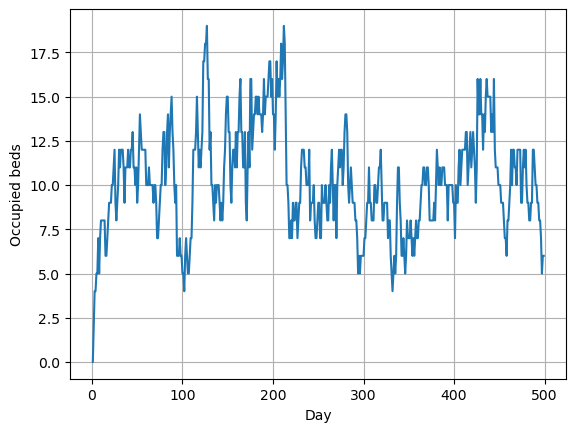

In [10]:
plot_beds(audit_time, audit_beds)

In [11]:
print_summary(audit_beds)

Mean: 10.3
Stdev: 2.9
5th percentile: 6.0
10th percentile: 7.0
25th percentile: 8.0
50th percentile: 10.0
75th percentile: 12.0
90th percentile: 14.0
95th percentile: 16.0
Max: 19.0
